In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1

## a

In [34]:
mri = cv2.imread('MRI.jpg', cv2.IMREAD_GRAYSCALE)
mri2 = cv2.imread('MRI2.jpg', cv2.IMREAD_GRAYSCALE)
points = []

# Mouse callback function
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append([x, y])
        # This draws a circle where you clicked
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('win', img)
        print(f"Point captured: ({x}, {y})")

# Source first, then Target
image_files = [mri2, mri]
all_points = []

for img in image_files:
    # Reset points list for the current image
    points = []
    cv2.namedWindow('win', cv2.WINDOW_NORMAL)
    cv2.imshow('win', img)
    
    # Link the mouse click to the window
    cv2.setMouseCallback('win', click_event)

    print(f"Click 3 corresponding points on {img}...")
    
    # Wait until 3 points are clicked
    while True:
        k = cv2.waitKey(1) & 0xFF
        if len(points) == 3:
            print(f"3 points selected for {img}. Press any key to continue...")
            cv2.waitKey(0) # Wait for a key press to confirm and move on
            break
        if k == 27: # Allow exiting with esc key
            break
            
    all_points.append(points)
    cv2.destroyAllWindows()

# Convert for Affine 
src_points = np.float32(all_points[0]) # From source
dst_points = np.float32(all_points[1]) # From target

# calculating the matrix automatically
affine_matrix = cv2.getAffineTransform(src_points, dst_points)
print("\nCalculated Affine Matrix:")
print(affine_matrix)

Click 3 corresponding points on [[ 9 10 10 ...  6  7  6]
 [ 4 12 18 ...  2  9  4]
 [13 19 11 ...  5 12  6]
 ...
 [10 11  6 ... 23 17  3]
 [17 11  8 ...  9 13 17]
 [12  7 10 ...  6  9 11]]...
Point captured: (44, 125)
Point captured: (160, 131)
Point captured: (162, 70)
3 points selected for [[ 9 10 10 ...  6  7  6]
 [ 4 12 18 ...  2  9  4]
 [13 19 11 ...  5 12  6]
 ...
 [10 11  6 ... 23 17  3]
 [17 11  8 ...  9 13 17]
 [12  7 10 ...  6  9 11]]. Press any key to continue...
Click 3 corresponding points on [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]...
Point captured: (158, 52)
Point captured: (186, 100)
Point captured: (214, 86)
3 points selected for [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]. Press any key to continue...

Calculated Affine Matrix:
[[  0.26467269  -0.4503386  202.64672686]
 [  0.40124153   0.24266366   4.01241535]]


## b

In [35]:
rows, cols = mri.shape
warped_img = cv2.warpAffine(mri2, affine_matrix, (cols, rows))

## c

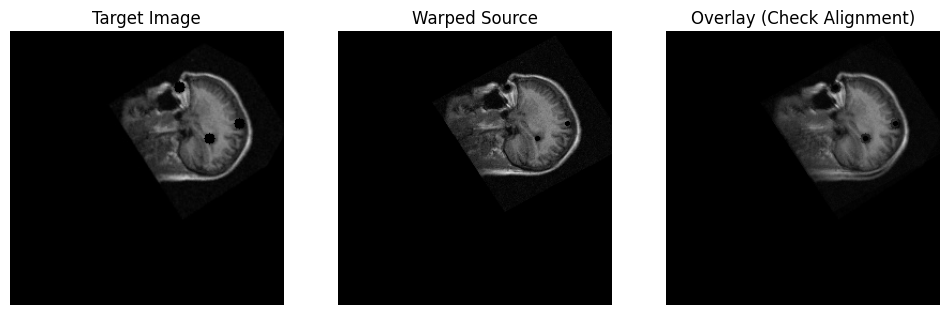

In [36]:
overlay = cv2.addWeighted(mri, 0.5, warped_img, 0.5, 0)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Target Image")
plt.imshow(cv2.cvtColor(mri, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Warped Source")
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay (For Alignment)")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Affine Transformation is a geometric operation that maps pixels from one coordinate system to another while preserving points, straight lines, and planes. The critical property of an affine transform is that *parallel lines remain parallel after the transformation*. This makes it ideal for correcting images there is translation, rotation, and scaling. 
- Mathematically, an affine transformation is defined by six parameters (or degrees of freedom) that control these movements. Because each point on a 2D image provides two values (an X and a Y coordinate), we need exactly three pairs of corresponding points to solve for these six unknowns. 

**Code:**

- In code, these three points form a triangle, and the algorithm calculates how to move, stretch, and rotate that triangle in the first image to perfectly match the triangle in the second image.
- First, cv2.getAffineTransform takes the two sets of coordinates and solves the linear system of equations to produce the 2×3 affine matrix. Then, cv2.warpAffine applies this matrix to the source image. The logic here is "inverse mapping": the function iterates over every pixel coordinate in the target destination, uses the inverse of the matrix to calculate where that pixel originated in the source image, and samples the intensity from that location.

**Point determination:**
Each single pair of corresponding points on the source image and its match on the target image provides two known values: one for the x coordinate and one for the y coordinate. This means that by every click, there'd be two equations to solve. Since we need six equations in total to solve for the six unknowns, and each point provides two equations, we need 3 points. If we provided only two points, we'd  have four equations for six unknowns, leaving the system "under-determined," meaning there would be infinite possible ways to warp the image that still satisfies your constraints. Moreover, if we had more than 3 points, the systems would be over-determined and thus, with no answer.

# 2

In [37]:
img = cv2.imread('shelf.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('shelf.jpg')
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE) 

## a, b, c altogether

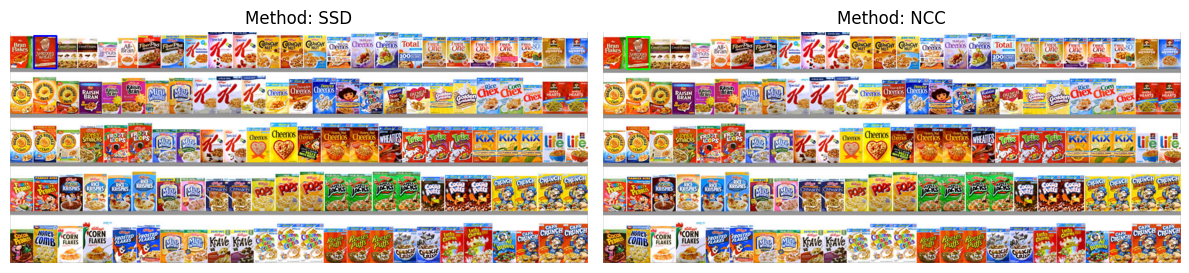

In [41]:
# Getting the dimensions for the final drawing
h, w = template.shape

# SSD
# Lower score(difference) = Better match.
res_ssd = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)

# location of the best match
# minMaxLoc returns 4 values: (min_value, max_value, min_location, max_location)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res_ssd)
top_left_ssd = min_loc
bottom_right_ssd = (top_left_ssd[0] + w, top_left_ssd[1] + h)

# Draw the rectangle on a copy of the image (Blue box for SSD)
img_ssd_result = img_color.copy()
cv2.rectangle(img_ssd_result, top_left_ssd, bottom_right_ssd, (255, 0, 0), 2)

# NCC, Higher score(correlation) = Better match.
res_ncc = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res_ncc)
top_left_ncc = max_loc
bottom_right_ncc = (top_left_ncc[0] + w, top_left_ncc[1] + h)

# Draw the rectangle on a copy of the image (Green box for NCC)
img_ncc_result = img_color.copy()
cv2.rectangle(img_ncc_result, top_left_ncc, bottom_right_ncc, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Method: SSD")
plt.imshow(cv2.cvtColor(img_ssd_result, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Method: NCC")
plt.imshow(cv2.cvtColor(img_ncc_result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

**SSD:**

The logic of SSD is based on calculating "difference" or error. As the template slides over the image, the algorithm subtracts the template pixel values from the image pixel values, squares the results (to eliminate negative numbers), and sums them up. In this logical framework, a perfect match results in a value of zero (because X−X=0). Therefore, the "best" match is the one with the lowest score. This is why the code uses cv2.minMaxLoc but specifically extracts the min_loc (minimum location). We are searching for the spot where the error is minimized.

**NCC:**

The second method is NCC, represented by cv2.TM_CCOEFF_NORMED. The logic here is fundamentally different: it calculates a statistical correlation coefficient. Instead of measuring error, it measures "similarity." The resulting score is a value between -1 and +1, where +1 indicates a perfect positive correlation (the images are identical). Because we are looking for the highest similarity, the "best" match is the one with the highest score. Consequently, the code logic flips: when we run cv2.minMaxLoc for this method, we ignore the minimum value and specifically extract the max_loc (maximum location).

# 3

## a

## b

## c